In [2]:
import pandas as pd
import requests
import folium
import geopandas as gpd
import shapely
from shapely.geometry import Polygon

In [3]:
PICKLE_PATH = "../data/pickled-chickens.pickle"
FSIS_DATA = "../data/fsis-processors-with-location.csv"

In [204]:
ALBERS_EQUAL_AREA = "EPSG:9822"
WGS84 = "EPSG:4326"

#### Load Chickens DF

In [205]:
df_large_chickens = pd.read_pickle(PICKLE_PATH)

In [206]:
df_large_chickens = gpd.GeoDataFrame(df_large_chickens).set_geometry("Isochrone")
df_large_chickens.head()

Unnamed: 0      EstNumber  EstID Parent Corporation Establishment Name   
71          71  P1317 + V1317   4495            Cargill    Wayne Farms LLC  \
72          72  P7485 + V7485   4518            Cargill    Wayne Farms LLC   
73          73           P912   4493            Cargill   Wayne Farms, LLC   
74          74  P7342 + V7342   4516            Cargill    Wayne Farms LLC   
75          75          P1235   4509            Cargill    Wayne Farms LLC   

   State   Size Animals Processed  Processed\nVolume\nCategory   
71    AL  Large           Chicken                          5.0  \
72    AL  Large           Chicken                          5.0   
73    AL  Large           Chicken                          5.0   
74    AL  Large           Chicken                          5.0   
75    AL  Large           Chicken                          5.0   

    Slaughter\nVolume\nCategory   
71                          5.0  \
72                          5.0   
73                          5.0   
74                          5.0   
75                          5.0   

                                         Full Address   latitude  longitude   
71         700 McDonald Avenue, Albertville, AL 35950  34.260726 -86.203222  \
72               1020 County Road 114, Jack, AL 36346  31.500628 -85.903438   
73  444 Baskin Street  South, Union Springs, AL 36089  32.139166 -85.721704   
74         808 Ross Clark Circle NE, Dothan, AL 36303  31.225754 -85.362068   
75                  254 Ipsco Road, Decatur, AL 35601  34.607601 -87.042595   

                                            Isochrone  
71  POLYGON ((-86.08922 34.94858, -86.09117 34.948...  
72  POLYGON ((-86.10144 32.28207, -86.10330 32.280...  
73  POLYGON ((-85.77570 32.87586, -85.77768 32.859...  
74  POLYGON ((-85.11607 32.00215, -85.11782 31.995...  
75  POLYGON ((-86.88059 35.31872, -86.88225 35.314...

In [207]:
df_large_chickens.set_crs(WGS84,inplace=True).head()

Unnamed: 0      EstNumber  EstID Parent Corporation Establishment Name   
71          71  P1317 + V1317   4495            Cargill    Wayne Farms LLC  \
72          72  P7485 + V7485   4518            Cargill    Wayne Farms LLC   
73          73           P912   4493            Cargill   Wayne Farms, LLC   
74          74  P7342 + V7342   4516            Cargill    Wayne Farms LLC   
75          75          P1235   4509            Cargill    Wayne Farms LLC   

   State   Size Animals Processed  Processed\nVolume\nCategory   
71    AL  Large           Chicken                          5.0  \
72    AL  Large           Chicken                          5.0   
73    AL  Large           Chicken                          5.0   
74    AL  Large           Chicken                          5.0   
75    AL  Large           Chicken                          5.0   

    Slaughter\nVolume\nCategory   
71                          5.0  \
72                          5.0   
73                          5.0   
74                          5.0   
75                          5.0   

                                         Full Address   latitude  longitude   
71         700 McDonald Avenue, Albertville, AL 35950  34.260726 -86.203222  \
72               1020 County Road 114, Jack, AL 36346  31.500628 -85.903438   
73  444 Baskin Street  South, Union Springs, AL 36089  32.139166 -85.721704   
74         808 Ross Clark Circle NE, Dothan, AL 36303  31.225754 -85.362068   
75                  254 Ipsco Road, Decatur, AL 35601  34.607601 -87.042595   

                                            Isochrone  
71  POLYGON ((-86.08922 34.94858, -86.09117 34.948...  
72  POLYGON ((-86.10144 32.28207, -86.10330 32.280...  
73  POLYGON ((-85.77570 32.87586, -85.77768 32.859...  
74  POLYGON ((-85.11607 32.00215, -85.11782 31.995...  
75  POLYGON ((-86.88059 35.31872, -86.88225 35.314...

In [208]:
# simplify the isochrones for improved processing time
df_large_chickens['Isochrone Cleaned'] = df_large_chickens['Isochrone'].simplify(.05)

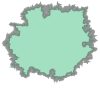

In [209]:
df_large_chickens.iloc[0]['Isochrone']

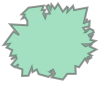

In [210]:
df_large_chickens.iloc[0]['Isochrone Cleaned']

In [211]:
# df_ga = df_large_chickens[df_large_chickens.State == 'GA']

In [212]:
df_large_chickens.State.unique()

array(['AL', 'AR', 'CA', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MN', 'MO',
       'MS', 'NC', 'NE', 'OK', 'PA', 'SC', 'TN', 'TX', 'VA', 'WA', 'WV',
       'IA'], dtype=object)

In [213]:
df_map = df_large_chickens

### Create Map

In [214]:
# center of the USA: 37.0902° N, 95.7129° W
USA_LAT = 37.0902
USA_LNG = -95.7129

In [215]:
empty_color = lambda x: {
    "fillColor": "00" # empty
}

one_plant_color = lambda x: {
    "fillColor": "#ED7117" # carrot
}

two_plant_color = lambda x: {
    "fillColor": "#ED7117" # carrot
}

three_plant_color = lambda x: {
    "fillColor": "#9F2B68" # amaranth
}

four_plant_color = lambda x: {
    "fillColor": "#90ee90" # light green
}

#### Add Plants and Isochrones to Map

In [216]:
# add markers and isochrones to map
isochrones = []
# driving_distance_layer = folium.map.FeatureGroup(name="60 Mile Driving Distance")
plants_layer = folium.map.FeatureGroup(name="Large Poultry Plants")

for index, row in df_map.iterrows():
    lat = str(row['latitude'])
    lng = str(row['longitude'])

    # set up plant tooltip
    name = row['Establishment Name']
    corp = row['Parent Corporation']
    address = row['Full Address']

    # add plant marker to map
    tooltip = folium.map.Tooltip(f"{name}<br>{address}<br>Parent Corporation: {corp}")
    folium.Marker(location=[lat, lng],tooltip=tooltip).add_to(plants_layer)

    isochrone = row['Isochrone Cleaned']
    isochrones.append(isochrone)
    # add driving radius isochrone to map layer
    # geojson = folium.GeoJson(row['Isochrone Cleaned'], style_function=empty_color)

    # geojson.add_to(driving_distance_layer)

In [217]:
len(isochrones)

138

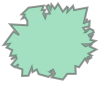

In [218]:
isochrones[0]

#### Calculate Single-Plant Capture

In [219]:
# tk if wanted, could include dictionary to have the info for each plant with the monopsony areas
single_plants_shapely = []
for index, poly in enumerate(isochrones):
    others = shapely.unary_union(isochrones[:index] + isochrones[index+1:])
    single_plant = shapely.difference(poly, others)
    single_plants_shapely.append(single_plant)

In [220]:
single_plant_layer = folium.map.FeatureGroup(name="Access to 1 Plant")
single_plants_combined = shapely.unary_union(single_plants_shapely)
folium.GeoJson(single_plants_combined).add_to(single_plant_layer)

In [221]:
# calculate competitive area for filtering in the next stage
everything = shapely.unary_union(isochrones)
single_plant_combined = shapely.unary_union(single_plants_shapely)
competition_single_plant = shapely.difference(everything, single_plant_combined)

#### Calculate Two Plant Capture

In [222]:
# exclude any plants that are fully in single plant capture area
isochrones_shapely_two_plants = []
for isochrone in isochrones:
    if isochrone.intersection(competition_single_plant):
        isochrones_shapely_two_plants.append(isochrone)

In [223]:
len(isochrones_shapely_two_plants)

131

In [224]:
two_plants_shapely = []
for i in range(len(isochrones_shapely_two_plants)):
    for j in range(i+1, len(isochrones_shapely_two_plants)):
        plant_1 = isochrones_shapely_two_plants[i]
        plant_2 = isochrones_shapely_two_plants[j]

        # check if there's an intersection between the areas
        if not plant_1.intersection(plant_2):
            continue
        else:
            two_plant_area = shapely.unary_union([plant_1,plant_2])

        # exclude first plant
        other_plants = isochrones_shapely_two_plants[:i]
        # exclude second plant
        other_plants += isochrones_shapely_two_plants[i+1:j]
        other_plants += isochrones_shapely_two_plants[j+1:]

        # find the area where there's only two plants
        others_combined = shapely.unary_union(other_plants)
        captured_area = shapely.difference(two_plant_area, others_combined) # returns the part of geometry a that does not intersect with geometry b
        # # remove the area that is captured by only one of the plants
        captured_area = shapely.difference(captured_area, single_plant_combined)
        if captured_area:
            two_plants_shapely.append(captured_area)


In [46]:
len(two_plants_shapely)

320

In [225]:
style_function = lambda x: {
    "fillColor": "#9F2B68" # amaranth
}

two_plant_layer = folium.map.FeatureGroup(name="Access to 2 Plants")
two_plants_combined = shapely.unary_union(two_plants_shapely)
folium.GeoJson(two_plants_combined,style_function=style_function).add_to(two_plant_layer)

In [226]:
# calculate competitive area for filtering in the next stage
competition_two_plant = shapely.difference(competition_single_plant, two_plants_combined)

#### Calculate Three Plant Competition Area

In [227]:
# exclude any plants that don't intersect with the competition area
isochrones_shapely_three_plants = []
for isochrone in isochrones:
    if isochrone.intersection(competition_two_plant):
        isochrones_shapely_three_plants.append(isochrone)

In [228]:
len(isochrones_shapely_three_plants)

126

In [229]:
three_plants_shapely = []
for i in range(len(isochrones_shapely_three_plants)):
    for j in range(i+1, len(isochrones_shapely_three_plants)):
        for k in range(j+1, len(isochrones_shapely_three_plants)):
            plant_1 = isochrones_shapely_three_plants[i]
            plant_2 = isochrones_shapely_three_plants[j]
            plant_3 = isochrones_shapely_three_plants[k]

            # check if there's an intersection between the areas
            if not plant_1.intersection(plant_2).intersection(plant_3):
                continue
            else:
                three_plant_area = shapely.unary_union([plant_1,plant_2,plant_3])

            # exclude first plant
            other_plants = isochrones_shapely_three_plants[:i]
            # exclude second plant
            other_plants += isochrones_shapely_three_plants[i+1:j]
            other_plants += isochrones_shapely_three_plants[j+1:k]
            # exclude third plant
            other_plants += isochrones_shapely_three_plants[k+1:]

            # find the area where there's only two plants
            others_combined = shapely.unary_union(other_plants)
            captured_area = shapely.difference(three_plant_area, others_combined) # returns the part of geometry a that does not intersect with geometry b
            # remove the area that is captured by only one of the plants
            captured_area = shapely.difference(captured_area, single_plant_combined)
            # remove the area that is captured by only two of the plants
            captured_area = shapely.difference(captured_area, two_plants_combined)
            if captured_area:
                three_plants_shapely.append(captured_area)


In [52]:
len(three_plants_shapely)

602

In [230]:
style_function = lambda x: {
    "fillColor": "#ED7117" # carrot
}

three_plant_layer = folium.map.FeatureGroup(name="Access to 3 Plants")
three_plants_combined = shapely.unary_union(three_plants_shapely)
folium.GeoJson(three_plants_combined,style_function=style_function).add_to(three_plant_layer)

#### Calculate 4+ Plant Competition Area

In [231]:
# 4+ plants is everything else that is left over
four_plants_combined = shapely.difference(everything, single_plant_combined)
four_plants_combined = shapely.difference(four_plants_combined, two_plants_combined)
four_plants_combined = shapely.difference(four_plants_combined.buffer(0), three_plants_combined.buffer(0)) # add buffer(0) to handle floating point errors

In [232]:
style_function = lambda x: {
    "fillColor": "#90ee90" # light green
}

four_plant_layer = folium.map.FeatureGroup(name="Access to 4+ Plants")
folium.GeoJson(four_plants_combined,style_function=style_function).add_to(four_plant_layer)

#### Calculate Captured Area

In [175]:
from pyproj import Geod

In [234]:
geod = Geod(ellps="WGS84")
poly_area, poly_perimeter = geod.geometry_area_perimeter(single_plant_combined)

In [236]:
geod.geometry_area_perimeter(everything)

(-1082302547003.0776, 38512710.4511868)

In [237]:
single_plant_area = abs(geod.geometry_area_perimeter(single_plant_combined)[0]/geod.geometry_area_perimeter(everything)[0])
two_plant_area = abs(geod.geometry_area_perimeter(two_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])
three_plant_area = abs(geod.geometry_area_perimeter(three_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])
four_plant_area = abs(geod.geometry_area_perimeter(four_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])

In [238]:
single_plant_area, two_plant_area, three_plant_area, four_plant_area

(0.5114533574793482,
 0.24346110393880524,
 0.11614870439096354,
 0.12893682694698932)

In [239]:
single_plant_area + two_plant_area + three_plant_area + four_plant_area

0.9999999927561063

#### Display Map

In [240]:
m = folium.Map(location=[USA_LAT, USA_LNG],zoom_start=4)

In [241]:
plants_layer.add_to(m)
# driving_distance_layer.add_to(m)
single_plant_layer.add_to(m)
two_plant_layer.add_to(m)
three_plant_layer.add_to(m)
four_plant_layer.add_to(m)
folium.map.LayerControl().add_to(m) # you need to add layer control *last* or else nothing will show up on the map
m

##### Save Map

In [189]:
m.save("../html/poultry-map-smoothed.html")

#### Include State Level Data

In [242]:
us_states = gpd.read_file("../data/gz_2010_us_040_00_500k.json").set_crs(WGS84)

In [243]:
us_states.head()

GEO_ID STATE           NAME LSAD  CENSUSAREA   
0  0400000US23    23          Maine        30842.923  \
1  0400000US25    25  Massachusetts         7800.058   
2  0400000US26    26       Michigan        56538.901   
3  0400000US30    30        Montana       145545.801   
4  0400000US32    32         Nevada       109781.180   

                                            geometry  
0  MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ...  
1  MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ...  
2  MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ...  
3  POLYGON ((-104.05770 44.99743, -104.25015 44.9...  
4  POLYGON ((-114.05060 37.00040, -114.04999 36.9...

In [244]:
us_states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [245]:
print(us_states.iloc[0]['geometry'].centroid)

POINT (-69.22532171969658 45.36948088392073)


In [246]:
df_large_chickens.State.unique()

array(['AL', 'AR', 'CA', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MN', 'MO',
       'MS', 'NC', 'NE', 'OK', 'PA', 'SC', 'TN', 'TX', 'VA', 'WA', 'WV',
       'IA'], dtype=object)

In [247]:
abb2state = {
    'AL': "Alabama", 
    'AR': "Arkansas", 
    'CA': "California", 
    'DE': "Delaware", 
    'FL': "Florida", 
    'GA': "Georgia", 
    'KY': "Kentucky", 
    'LA': "Louisiana", 
    'MD': "Maryland", 
    'MN': "Minnesota", 
    'MO': "Missouri",
    'MS': "Mississippi", 
    'NC': "North Carolina", 
    'NE': "Nebraska", 
    'OK': "Oklahoma", 
    'PA': "Pennsylvania", 
    'SC': "South Carolina", 
    'TN': "Tennessee", 
    'TX': "Texas", 
    'VA': "Virginia", 
    'WA': "Washington", 
    'WV': "West Virginia",
    'IA': "Iowa"
}

In [343]:
# highlight function (change displayed on hover)
state_function = lambda x: {
  'color': 'red', # stroke becomes red
  'fillColor': '#00000000',
  # 'opacity' : 0.9,
  # 'weight': 4,
  'dashArray' : '3, 6' # transforms the solid stroke to a dashed stroke
}

In [344]:
mm = folium.Map(location=[USA_LAT, USA_LNG],zoom_start=4)

In [345]:
# create layers for each state
for state in df_large_chickens.State.unique():
    state_name = abb2state[state]
    state_layer = folium.map.FeatureGroup(name=state_name, show=False)
    state_geometry = us_states[us_states["NAME"] == state_name]['geometry'].to_crs(WGS84)
    state_center = state_geometry.to_crs(ALBERS_EQUAL_AREA).centroid.to_crs(WGS84)

    one_plant = shapely.intersection(single_plant_combined,state_geometry).set_crs(WGS84).iloc[0]
    two_plant = shapely.intersection(two_plants_combined,state_geometry).set_crs(WGS84).iloc[0]
    three_plant = shapely.intersection(three_plants_combined.buffer(0),state_geometry).set_crs(WGS84).iloc[0]
    four_plant = shapely.intersection(four_plants_combined,state_geometry).set_crs(WGS84).iloc[0]
    
    everything = shapely.unary_union([one_plant, two_plant, three_plant, four_plant])
    everything_area = geod.geometry_area_perimeter(everything)[0]

    # if state=="DE":
    #     # print(one_plant)
    #     # print(two_plant)
    #     # print(three_plant)
    #     # print(four_plant)
    #     # print(everything)
    #     # print(everything_area)
    #     print(geod.geometry_area_perimeter(one_plant)[0])
    #     print(geod.geometry_area_perimeter(two_plant)[0])
    #     print(geod.geometry_area_perimeter(three_plant)[0])
    #     print(geod.geometry_area_perimeter(four_plant)[0])
    #     print(everything_area)

    # calculate captured area
    single_plant_area = abs(geod.geometry_area_perimeter(one_plant)[0]/everything_area)
    two_plant_area = abs(geod.geometry_area_perimeter(two_plant)[0]/everything_area)
    three_plant_area = abs(geod.geometry_area_perimeter(three_plant)[0]/everything_area)
    four_plant_area = abs(geod.geometry_area_perimeter(four_plant)[0]/everything_area)
    # except Exception as e:
    #     print(f"{state_name} has an exception")
    #     two_plant_area = 0
    #     three_plant_area = 0
    #     four_plant_area = 0
    #     # continue

    # if state=="DE":
    #     print(single_plant_area)
    #     print(two_plant_area)
    #     print(three_plant_area)
    #     print(four_plant_area)

    tooltip = folium.map.Tooltip(f'1 Plant: {single_plant_area:.1%}<br>2 Plants: {two_plant_area:.1%}<br>3 Plants: {three_plant_area:.1%}<br>4+ Plants: {four_plant_area:.1%}<br>')              
    # {name}<br>{address}<br>Parent Corporation: {corp}")
    state_marker = folium.Marker(location=[state_center.y.iloc[0],state_center.x.iloc[0]],tooltip=tooltip,icon=folium.map.Icon(color='white')).add_to(state_layer)

    folium.GeoJson(state_geometry, style_function=state_function).add_to(state_layer)
    folium.GeoJson(one_plant).add_to(state_layer)
    folium.GeoJson(two_plant, style_function=two_plant_color).add_to(state_layer)
    folium.GeoJson(three_plant, style_function=three_plant_color).add_to(state_layer)
    folium.GeoJson(four_plant, style_function=four_plant_color).add_to(state_layer)

    state_layer.add_to(mm)

In [346]:
plants_layer.add_to(mm)
folium.map.LayerControl().add_to(mm)

In [347]:
mm

In [348]:
mm.save("../html/poultry-state-map.html")

In [224]:
one_plant_ga = shapely.intersection(single_plant_combined,us_states[us_states["NAME"] == "Georgia"]['geometry']).set_crs("EPSG:4326")
two_plant_ga = shapely.intersection(two_plants_combined,us_states[us_states["NAME"] == "Georgia"]['geometry']).set_crs("EPSG:4326")
three_plant_ga = shapely.intersection(three_plants_combined,us_states[us_states["NAME"] == "Georgia"]['geometry']).set_crs("EPSG:4326")
four_plant_ga = shapely.intersection(four_plants_combined,us_states[us_states["NAME"] == "Georgia"]['geometry']).set_crs("EPSG:4326")

In [218]:
one_plant_ga

28    MULTIPOLYGON (((-85.04724 31.12008, -85.00485 ...
Name: geometry, dtype: geometry

In [228]:
all_ga = shapely.unary_union([one_plant_ga, two_plant_ga, three_plant_ga, four_plant_ga])

In [235]:
plants_layer.add_to(mm)
driving_distance_layer.add_to(mm)

In [238]:
folium.GeoJson(one_plant_ga).add_to(mm)
folium.GeoJson(two_plant_ga, style_function=two_plant_color).add_to(mm)
folium.GeoJson(three_plant_ga, style_function=three_plant_color).add_to(mm)
folium.GeoJson(four_plant_ga, style_function=four_plant_color).add_to(mm)

In [239]:
mm

#### Old Code

In [100]:
captured_area = shapely.unary_union(captured_list)

In [101]:
two_plants_map = folium.GeoJson(captured_area)

In [102]:
type(two_plants_map)

folium.features.GeoJson

In [103]:
two_plants_layer = folium.map.FeatureGroup(two_plants_map)

In [105]:
folium.map.LayerControl().add_to(m) # you need to add layer control *last* or else nothing will show up on the map
m

TypeError: Object of type GeoJson is not JSON serializable

In [26]:
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data"
)
state_geo = f"{url}/us-states.json"

In [27]:
state_geo

'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json'

In [ ]:
# can connect these using state from the dataframe
# grouped layer control may enable the desired behavior?
# https://python-visualization.github.io/folium/plugins.html?highlight=groupedlayercontrol#folium.plugins.GroupedLayerControl

# for each layer, iterate over and add the intersection for the specific state?
# or is it only the actual calculation that matters for each state?

##### Find Monopsony Areas

#### Show Areas Capture By Two Plants

In [ ]:
# create a geojson with every possible intersection between two areas
# find the difference between that area and the competition area
# need to rebuild the competition piece every time?
# exclude the plants that are outside of the competition area to save computation time

In [17]:
comp_map = shapely.unary_union(competition)

In [18]:
mm = folium.Map(location=[usa_lat, usa_lng],zoom_start=4)

In [21]:
for index, row in df_large_chickens.iterrows():
    lat = str(row['latitude'])
    lng = str(row['longitude'])

    # add poultry plant to map
    folium.Marker(location=[lat, lng]).add_to(mm)

In [23]:
mm.save("../html/single-poultry-plant-map.html")

#### Old Code

In [45]:
folium.GeoJson(intersection, name="isochrone").add_to(m)

In [47]:
def style_function(feature):
    return {
        'fillColor': 'red',
        'color': 'red'
    }

# Create a map and add the GeoJSON layer
mm = folium.Map()
folium.GeoJson(intersection, style_function=style_function).add_to(mm)

In [95]:
shape_flipped = []
for coord in shape:
    coord[0], coord[1] = coord[1], coord[0]
    shape_flipped.append(coord)

In [96]:
shape_flipped

[[34.020723, -112.141559],
 [34.020649, -112.14457],
 [34.019655, -112.142564],
 [34.01766, -112.142467],
 [34.016104, -112.140115],
 [34.012149, -112.13807],
 [34.008361, -112.138559],
 [34.00886, -112.147359],
 [34.010578, -112.150559],
 [34.00866, -112.155067],
 [34.003667, -112.149552],
 [33.998969, -112.149868],
 [33.998441, -112.154779],
 [34.000789, -112.15543],
 [34.006218, -112.162001],
 [34.005895, -112.165794],
 [33.998677, -112.160542],
 [33.99788, -112.155339],
 [33.995422, -112.154797],
 [33.994302, -112.149917],
 [33.990103, -112.153002],
 [33.989607, -112.159559],
 [33.986547, -112.162559],
 [33.986399, -112.165559],
 [33.990843, -112.168375],
 [33.99114, -112.175039],
 [33.986034, -112.175933],
 [33.98466, -112.178567],
 [33.982244, -112.176975],
 [33.981451, -112.174768],
 [33.982921, -112.165559],
 [33.979836, -112.162559],
 [33.982678, -112.159559],
 [33.982385, -112.147559],
 [33.977066, -112.146153],
 [33.97266, -112.140846],
 [33.969115, -112.141559],
 [33.97205,

In [ ]:
# $ curl "https://api.mapbox.com/isochrone/v1/mapbox/driving/-118.22258,33.99038?contours_minutes=5,10,15&contours_colors=6706ce,04e813,4286f4&polygons=true&access_token=YOUR_MAPBOX_ACCESS_TOKEN"


In [29]:
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from pyproj import Geod
from shapely.geometry import Point, LineString

line_string = LineString([Point(-1.154321, 55.124412), Point(-1.2354352, 56.2345235)])
geod = Geod(ellps="WGS84")
geod.geometry_length(line_string)


123700.61484174021

In [32]:
polygons = []
geod = Geod(ellps="WGS84")
# check for circle intersections
for i in range(len(circles)):
    for j in range(i+1, len(circles)):
        c1 = circles[i]
        c2 = circles[j]
        point1 = Point(c1.location[1], c1.location[0])
        point2 = Point(c2.location[1], c2.location[0])

        line_string = LineString([point1, point2])
        dist = geod.geometry_length(line_string)/1609.34

        print(dist)
        if dist < 100: # there is some overlap if distance is less than the radius of the circles
            intersection = Polygon(c1.intersections(c2).get_bounds())
            polygons.append(intersection)
        break

190.99994442141886
45.275702925434125


AttributeError: 'Circle' object has no attribute 'intersections'